# Imports

In [26]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics

import feather
import os
import time

In [27]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

ModuleNotFoundError: No module named 'keras'

## Data

train_limited represents a subset of the entire training set, sampled to reflect the distribution of phases found in the test set

In [28]:
limited_path = 'train_limited.feather'

In [29]:
train_limited = feather.read_dataframe(limited_path)

train_labels contains the final turbidity for each unique process_id

In [30]:
label_path = 'train_labels.feather'
feather.write_dataframe(train_labels, path)

In [31]:
train_labels = feather.read_dataframe(label_path)

# Feature Engineering

Collect each process into a single sequence

Pad entries so they are uniform in length

So, in essence we want a three-dimension matrix of shape (m, T, f) - where m is the number of unique processes, T is the number of time-sequences, and f is the number of features

In order to do that, I think I'll need to group the data by the process_id, and then somehow split each group into it's own 2-dimensional matrix

ts_cols are the columns that seemed most valuable to keep (based on the Benchmark Notebook)

In [32]:
ts_cols = [
    'timestamp',
    'process_id',
    'pipeline',
    'phase',
    'object_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
]

train_converted just converts any non-numeric values into numbers (which is basically just the pipeline number)

In [33]:
train_converted = pd.get_dummies(train_limited[ts_cols])

In [7]:
len(train_converted.groupby('process_id').nunique())

4902

## Separate matrices by column

Plan: Create m different matrices of size (? x f) by looping over the process_id and separating them into different tensors

Step 1: Figure out the dimensions of each process_id -- we know each process has a set number of features (columns), but they vary by number of rows (a.k.a. number of timestamps)

A. Get a list of all the process_ids

In [37]:
ids = train_converted.process_id.unique()

In [39]:
print(len(ids))

4902


B. Inspect some example process_ids

In [41]:
tc_0 = train_converted[train_converted.process_id == ids[0]]

In [42]:
tc_0

,timestamp,process_id,object_id,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,phase_acid,phase_caustic,phase_intermediate_rinse,phase_pre_rinse
0,2018-04-15 04:20:47,20001,405,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2018-04-15 04:20:49,20001,405,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,2018-04-15 04:20:51,20001,405,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,2018-04-15 04:20:53,20001,405,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,2018-04-15 04:20:55,20001,405,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
5,2018-04-15 04:20:57,20001,405,18710.215,0.944444,18.583622,0.509684,0.166377,4918.9814,55.445602,41.647675,44.048030,49.462350,32.385708,82.993350,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
6,2018-04-15 04:20:59,20001,405,21216.725,1.032118,18.460648,0.443773,0.292969,6188.5127,55.436195,41.628872,44.048030,49.462350,32.385708,82.993350,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
7,2018-04-15 04:21:01,20001,405,22403.066,1.087891,18.420862,0.521089,0.271267,7606.3364,55.422090,41.603010,44.052734,49.462350,32.367622,82.953560,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8,2018-04-15 04:21:03,20001,405,23278.357,1.140842,18.420862,0.779835,0.361690,8586.5170,55.407990,41.565395,44.052734,49.462350,32.367622,82.953560,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
9,2018-04-15 04:21:05,20001,405,24178.965,1.191623,18.377459,1.552591,0.358073,9393.0850,55.393883,41.534830,44.052734,49.462350,32.367622,82.953560,73.032410,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [43]:
tc_1 = train_converted[train_converted.process_id == ids[1]]

In [47]:
tc_1.shape[1]

31

Conclusion: They have the same number of columns (31), but the number of rows varies

C. Get the row-counts for all the process_ids

In [49]:
rows = []
for i in ids:
    process = train_converted[train_converted.process_id == i]
    rows.append(process.shape[0])

In [58]:
rows

[1425,
 446,
 1720,
 373,
 254,
 1104,
 2212,
 783,
 574,
 744,
 204,
 707,
 855,
 729,
 591,
 828,
 1115,
 1734,
 873,
 1718,
 303,
 537,
 856,
 938,
 114,
 914,
 618,
 56,
 786,
 901,
 751,
 818,
 417,
 629,
 478,
 629,
 1700,
 947,
 735,
 416,
 458,
 678,
 754,
 638,
 445,
 1601,
 834,
 565,
 1056,
 915,
 474,
 958,
 266,
 836,
 739,
 2296,
 544,
 1261,
 823,
 675,
 651,
 642,
 459,
 606,
 440,
 1614,
 175,
 1183,
 658,
 1028,
 753,
 819,
 665,
 347,
 568,
 412,
 561,
 344,
 367,
 207,
 527,
 961,
 783,
 1372,
 764,
 625,
 2009,
 443,
 720,
 1315,
 844,
 504,
 717,
 523,
 413,
 1119,
 1543,
 1116,
 457,
 770,
 1292,
 805,
 298,
 1615,
 1606,
 904,
 59,
 1851,
 965,
 179,
 406,
 452,
 1369,
 422,
 935,
 25,
 1339,
 515,
 252,
 250,
 1609,
 497,
 848,
 919,
 435,
 1245,
 704,
 484,
 412,
 768,
 506,
 1458,
 595,
 806,
 775,
 627,
 1694,
 448,
 920,
 409,
 1058,
 626,
 433,
 550,
 746,
 1136,
 531,
 1356,
 445,
 2194,
 1684,
 694,
 438,
 1357,
 903,
 27,
 1830,
 966,
 431,
 455,
 479,


Alright, now we have a list of all the row-counts  
Let's double check the dimensions of the list (it should have 4902 entries, the number of distinct process_ids)

In [57]:
len(rows)

4902

Bingo!

Now let's visualize these lengths, get a sense for how they're distributed

{'whiskers': [<matplotlib.lines.Line2D at 0x7f189e58b518>,
 'caps': [<matplotlib.lines.Line2D at 0x7f189e58b0f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f189e58b940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f17b4374860>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f17b4374ba8>],
 'means': []}

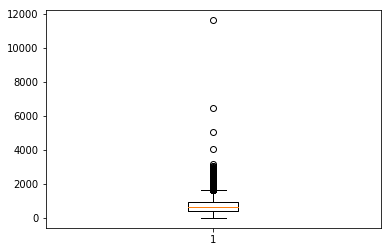

In [59]:
plt.boxplot(rows)

Okay, so, median somewhere around a 1000, deep right-skew

Convert the train_converted Dataframe into a numpy array

In [ ]:
tc_array = train_converted.values